*Copyright (c) Cornac Authors. All rights reserved.*

*Licensed under the Apache 2.0 License.*

# Model Ensembling

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/cornac/blob/master/tutorials/model_ensembling.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/cornac/blob/master/tutorials/model_ensembling.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook provides an example of how to ensemble multiple recommendation models in Cornac.

Ensemble models is a technique that combines the predictions of multiple models to produce a single prediction. The idea is that by combining the predictions of multiple models, we can improve the overall performance of the recommendation system.

We will use the MovieLens 100K dataset and ensemble 2 models.

** Note: ** This notebook requires the `scikit-learn` package. 

## 1. Setup

### Install required dependencies

In [1]:
! pip install seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.data import Dataset
from cornac.models import BPR, WMF

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

/home/darrylong/miniconda3/envs/cornac/lib/python3.9/site-packages/tqdm-4.65.0-py3.9.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Prepare Experiment

### Loading Dataset

First, we load the MovieLens 100K dataset.

In [3]:
data = movielens.load_feedback(variant="100K") # load dataset
dataset = Dataset.from_uir(data) # convert to Dataset object

### Training BPR and WMF models

We will train two models: 

1. BPR (Bayesian Personalized Ranking)
2. WMF (Weighted Matrix Factorization)

In [4]:
# Train BPR model
bpr_model = BPR(k=10, max_iter=100, learning_rate=0.01, lambda_reg=0.001)
bpr_model.fit(dataset)

# Train WMF model
wmf_model = WMF(k=10, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,)
wmf_model.fit(dataset)

100%|██████████| 100/100 [00:04<00:00, 23.05it/s, loss=108]   

Learning completed!


### Reviewing Individual Trained Models

These models are trained and evaluated individually. The scores of the models will be used to ensemble the models.

Let's see what the prediction scores of user index 0 looks like.
Take note that user index '0' may not correspond to user ID '0', depending on how the dataset is loaded.

This prints scores of all items for user index 0. The higher the score, the more likely the user will like the item.

In [12]:
# get item ids scores
print("BPR scores for user idx 0:", bpr_model.score(0)) # get BPR scores of user idx 0
print("WMF scores for user idx 0:", wmf_model.score(0)) # get WMF scores of user idx 0

BPR scores for user idx 0: [ 2.5407927   3.2257416  -0.90109813 ... -2.0262032  -2.0933206
 -2.1515543 ]
WMF scores for user idx 0: [3.5014405  3.467132   1.1731424  ... 0.23383346 0.2283108  0.23851925]


## 3. Perform Model Ensembling

Prepare the data for the ensemble model. We will use the predictions of the individual models as features for the ensemble model.

In [7]:
# Get all scores

uidx_list = [0]
# uidx_list = range(dataset.num_users)

scores_bpr = np.array([bpr_model.score(uid) for uid in uidx_list])
scores_wmf = np.array([wmf_model.score(uid) for uid in uidx_list])

scores_bpr = scores_bpr.flatten()
scores_wmf = scores_wmf.flatten()

print("BPR scores shape:", scores_bpr.shape)
print("WMF scores shape:", scores_wmf.shape)

X_train = np.array(2 * [(uid, iid) for iid in range(dataset.num_items) for uid in uidx_list])
y_train = np.concatenate((scores_bpr, scores_wmf))

print(X_train.shape, y_train.shape)

BPR scores shape: (1682,)
WMF scores shape: (1682,)
(3364, 2) (3364,)


Next, we train this ensemble model.

We use a bagging ensemble model with a decision tree as the base estimator.



### Training models

In [8]:
base_model = DecisionTreeRegressor(random_state=42)
bagging_model = BaggingRegressor(base_model, n_estimators=10)
adaboost_model = AdaBoostRegressor(base_model, n_estimators=50)

randomforest_model = RandomForestRegressor(n_estimators=200, random_state=42)

# bagging_model.fit(X_train, y_train)
adaboost_model.fit(X_train, y_train)
randomforest_model.fit(X_train, y_train)





RandomForestRegressor(n_estimators=200, random_state=42)

## 4. New Model Prediction

### Prediction for a given input

In [15]:
print(adaboost_model.predict([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]))

adaboost_scores = adaboost_model.predict([(uid, iid) for iid in range(dataset.num_items) for uid in uidx_list])
randomforest_scores = randomforest_model.predict([(uid, iid) for iid in range(dataset.num_items) for uid in uidx_list])

[2.96228635 3.2567482  0.41904405 1.53801966 2.0800821 ]


In [47]:
df = pd.DataFrame({
    'itemindex': 4 * [iid for iid in range(dataset.num_items) for _ in uidx_list],
    'score': np.concatenate((scores_bpr, scores_wmf, adaboost_scores, randomforest_scores)),
    'model': ['bpr'] * dataset.num_items * len(uidx_list) + ['wmf'] * dataset.num_items * len(uidx_list) + ['adaboost'] * dataset.num_items * len(uidx_list) + ['randomforest'] * dataset.num_items * len(uidx_list),
})

# sns.scatterplot(x=df['iid'], y=df['score'], hue=df['model'])

Let's compare the scores of the ensemble model with the individual models.

<Axes: xlabel='itemindex', ylabel='score'>

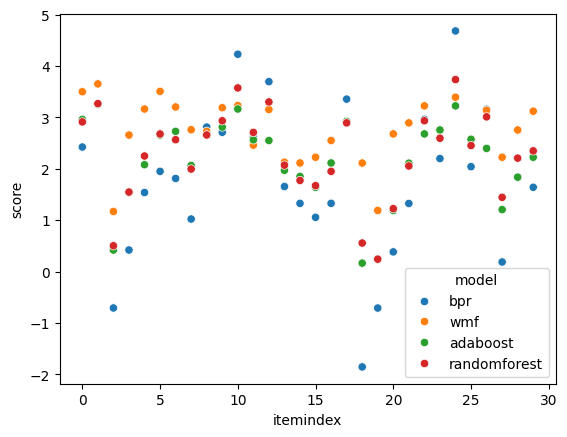

In [48]:
# Get first 30 items and visualize them.
sub_df = df[df['itemindex'] < 30]

sns.scatterplot(x=sub_df['itemindex'], y=sub_df['score'], hue=sub_df['model'])


### Obtaining top N items for each model

#### Using pandas DataFrame

The following code snippet shows how to obtain the top N items for each model using pandas.

Comparing top N items between models. Take note that these are item indexes instead of item IDs.

In [49]:
n = 10

bpr_df = df[df['model'] == 'bpr'].nlargest(n, 'score')

wmf_df = df[df['model'] == 'wmf'].nlargest(n, 'score')

adaboost_df = df[df['model'] == 'adaboost'].nlargest(n, 'score')
print(adaboost_df)

randomforest_df = df[df['model'] == 'randomforest'].nlargest(n, 'score')
print(randomforest_df)

bpr_top_n = bpr_df['itemindex'].values
print("bpr item recommendations:", list(bpr_top_n))
wmf_top_n = wmf_df['itemindex'].values
print("wmf item recommendations:", list(wmf_top_n))
adaboost_top_n = adaboost_df['itemindex'].values
print("adaboost item recommendations:", list(adaboost_top_n))
randomforest_top_n = adaboost_df['itemindex'].values
print("randomforest item recommendations:", list(randomforest_top_n))



      itemindex     score     model
3721        357  4.290173  adaboost
3413         49  3.659263  adaboost
3731        367  3.600322  adaboost
3685        321  3.518769  adaboost
3416         52  3.500956  adaboost
3618        254  3.449534  adaboost
3611        247  3.444049  adaboost
3768        404  3.418372  adaboost
3497        133  3.373223  adaboost
3465        101  3.347372  adaboost
      itemindex     score         model
5403        357  4.266278  randomforest
5095         49  3.982518  randomforest
5098         52  3.931262  randomforest
5413        367  3.891609  randomforest
5147        101  3.849832  randomforest
5367        321  3.814457  randomforest
5070         24  3.737004  randomforest
5203        157  3.628152  randomforest
5135         89  3.595573  randomforest
5537        491  3.591587  randomforest
bpr item recommendations: [357, 49, 367, 321, 52, 24, 600, 101, 10, 491]
wmf item recommendations: [357, 189, 239, 719, 174, 49, 1, 130, 297, 512]
adaboost item rec

To map it back into Item IDs, we use the iid_map which gives us item ID to index mappings.

In [46]:
iid_to_index_list = list(dataset.iid_map.items())

print(iid_to_index_list)

bpr_top_n_iid = [iid_to_index_list[item_idx][0] for item_idx in bpr_top_n]
wmf_top_n_iid = [iid_to_index_list[item_idx][0] for item_idx in wmf_top_n]
adaboost_top_n_iid = [iid_to_index_list[item_idx][0] for item_idx in adaboost_top_n]
randomforest_top_n_iid = [iid_to_index_list[item_idx][0] for item_idx in randomforest_top_n]

print("bpr item recommendations:", bpr_top_n_iid)
print("wmf item recommendations:", wmf_top_n_iid)
print("adaboost item recommendations:", adaboost_top_n_iid)
print("randomforest item recommendations:", randomforest_top_n_iid)

[('242', 0), ('302', 1), ('377', 2), ('51', 3), ('346', 4), ('474', 5), ('265', 6), ('465', 7), ('451', 8), ('86', 9), ('257', 10), ('1014', 11), ('222', 12), ('40', 13), ('29', 14), ('785', 15), ('387', 16), ('274', 17), ('1042', 18), ('1184', 19), ('392', 20), ('486', 21), ('144', 22), ('118', 23), ('1', 24), ('546', 25), ('95', 26), ('768', 27), ('277', 28), ('234', 29), ('246', 30), ('98', 31), ('193', 32), ('88', 33), ('194', 34), ('1081', 35), ('603', 36), ('796', 37), ('32', 38), ('16', 39), ('304', 40), ('979', 41), ('564', 42), ('327', 43), ('201', 44), ('1137', 45), ('241', 46), ('4', 47), ('332', 48), ('100', 49), ('432', 50), ('322', 51), ('181', 52), ('196', 53), ('679', 54), ('384', 55), ('143', 56), ('423', 57), ('515', 58), ('20', 59), ('288', 60), ('219', 61), ('526', 62), ('919', 63), ('26', 64), ('232', 65), ('427', 66), ('512', 67), ('15', 68), ('1049', 69), ('416', 70), ('165', 71), ('690', 72), ('248', 73), ('1444', 74), ('5', 75), ('229', 76), ('237', 77), ('480'